# Pixel Threshold

Notebook that explores different pixel thresholds in preparing the true binary dataset for training.

In [2]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [3]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [4]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [5]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


In [6]:
N_examples = len(data_noisy)
print(f"Number of images: {N_examples}")

Number of images: 6400


**Data Preperation**

In [7]:
nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

In [8]:
def data_aug_threshold(data_noisy, data_true, threshold):
    data_true_binary = np.zeros((64*chunk_tot, 56, 56))
    data_true_binary[data_true>threshold] = 1
    data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))
    
    # Putting them to the right form with normalization
    data_noisy_arr = data_noisy[images_high_mask]
    data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
    data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

    data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
    data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()
    
    # Split train and test

    N, w, h = data_noisy_tensor.shape
    idx_split = int(N*0.8) # 80% training, 20% testing
    
    data_noisy_train = data_noisy_tensor[:idx_split]
    data_true_train = data_true_tensor[:idx_split]
    data_noisy_test = data_noisy_tensor[idx_split:]
    data_true_test = data_true_tensor[idx_split:]

    data_noisy_train_im = data_noisy_tensor_im[:idx_split]
    data_true_train_im = data_true_tensor_im[:idx_split]
    data_noisy_test_im = data_noisy_tensor_im[idx_split:]
    data_true_test_im = data_true_tensor_im[idx_split:]
    
    return data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split




**Show what the effect of the pixel threshold is**

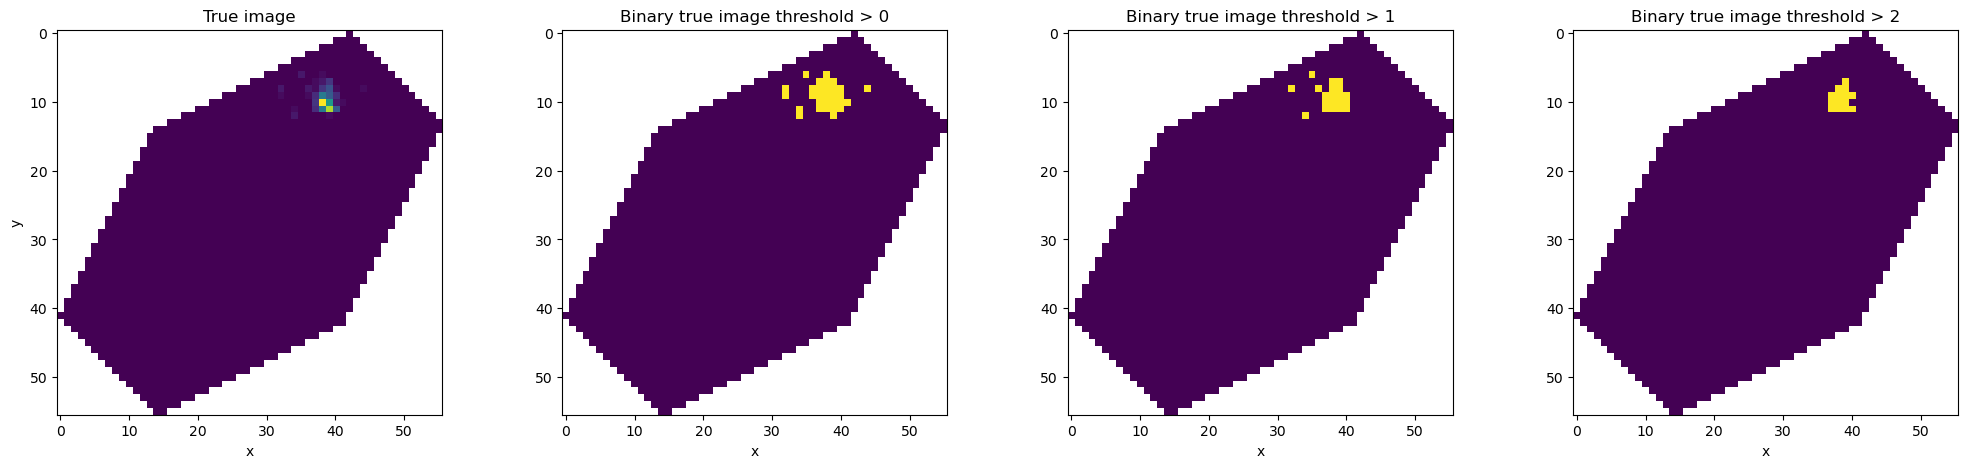

In [12]:
data_noisy_train, data_true_train, data_noisy_test, data_true_test0, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_aug_threshold(data_noisy, data_true, 0)
data_noisy_train, data_true_train, data_noisy_test, data_true_test1, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_aug_threshold(data_noisy, data_true, 1) 
data_noisy_train, data_true_train, data_noisy_test, data_true_test2, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_aug_threshold(data_noisy, data_true, 2)
    
im_i = 26
    
fig_thres_ex, axs = plt.subplots(1,4,figsize=(25,5))

axs[0].imshow(data_true_test_im[im_i], vmin=0)
axs[0].set_title("True image")
axs[0].set_ylabel("y")
axs[0].set_xlabel("x")
    
true_threshold_0 = data_true_test0[im_i].reshape(56,56).detach().numpy()
true_threshold_0[nan_mask] = np.nan
axs[1].imshow(true_threshold_0)
axs[1].set_title("Binary true image threshold > 0")
axs[1].set_xlabel("x")
    
true_threshold_1 = data_true_test1[im_i].reshape(56,56).detach().numpy()
true_threshold_1[nan_mask] = np.nan
axs[2].imshow(true_threshold_1)
axs[2].set_title("Binary true image threshold > 1")
axs[2].set_xlabel("x")

true_threshold_2 = data_true_test2[im_i].reshape(56,56).detach().numpy()
true_threshold_2[nan_mask] = np.nan
axs[3].imshow(true_threshold_2)
axs[3].set_title("Binary true image threshold > 2")
axs[3].set_xlabel("x")


plt.show()    

fig_thres_ex.savefig("images/ThresholdExample.pdf")



**The Autoencoder Model**

In [16]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        x = x.reshape(1, 56*56)
        
        return x         

**Fitting Functions**

In [17]:
def IOU_calc(clean_iou, true_iou): 
    clean_sum = torch.sum(clean_iou)
    true_sum = torch.sum(true_iou)
    true_iou2 = torch.zeros(true_iou.shape)
    
    true_iou2[true_iou==0] = 2 
    true_iou2[true_iou==1] = 1
    
    intersection_arr = (clean_iou==true_iou2)
    intersection_sum = torch.sum(intersection_arr)
    
    IOU = intersection_sum/(clean_sum+true_sum-intersection_sum)
    
    return IOU

In [18]:
# Functions and definitions for 
n_epochs = 15

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):      
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true, true_good in zip(data_noisy_test, data_true_test, data_true_test_all):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true_good)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [19]:
test_losses_all = []
IOU_all = []

**Pixel Threshold > 0**

In [20]:
# One time to obtain the normal image

data_noisy_train, data_true_train, data_noisy_test, data_true_test_all, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_aug_threshold(data_noisy, data_true, 0)

In [21]:
# Functions and definitions for 
n_epochs = 15

weight = 2

# This is the main training loop
def train(epoch):
    network0.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):   
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)        
        
        i=i+1
        optimizer.zero_grad()
        output = network0(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network0.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true, true_good in zip(data_noisy_test, data_true_test, data_true_test_all):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network0(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true_good)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [22]:
%%time

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

learning_rate = 0.001

network0 = AE4()
optimizer = torch.optim.Adam(network0.parameters(), lr=learning_rate)


data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_aug_threshold(data_noisy, data_true, 0)
    
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)
IOU_all.append(IOU_list)


Test set: Avg. loss: 0.5572
IOU: 0.002912025200203061
Training set: Avg. loss: 0.1212

Test set: Avg. loss: 0.0862
IOU: 0.41041597723960876
Training set: Avg. loss: 0.0979

Test set: Avg. loss: 0.0778
IOU: 0.4501896798610687
Training set: Avg. loss: 0.0912

Test set: Avg. loss: 0.0753
IOU: 0.4656951129436493
Training set: Avg. loss: 0.0876

Test set: Avg. loss: 0.0749
IOU: 0.4725792706012726
Training set: Avg. loss: 0.0870

Test set: Avg. loss: 0.0729
IOU: 0.4826555550098419
Training set: Avg. loss: 0.0840

Test set: Avg. loss: 0.0720
IOU: 0.4812696576118469
Training set: Avg. loss: 0.0835

Test set: Avg. loss: 0.0719
IOU: 0.4795803129673004
Training set: Avg. loss: 0.0823

Test set: Avg. loss: 0.0710
IOU: 0.490511953830719
Training set: Avg. loss: 0.0832

Test set: Avg. loss: 0.0736
IOU: 0.4770352840423584
Training set: Avg. loss: 0.0809

Test set: Avg. loss: 0.0715
IOU: 0.48599591851234436
Training set: Avg. loss: 0.0805

Test set: Avg. loss: 0.0717
IOU: 0.48676061630249023
Training

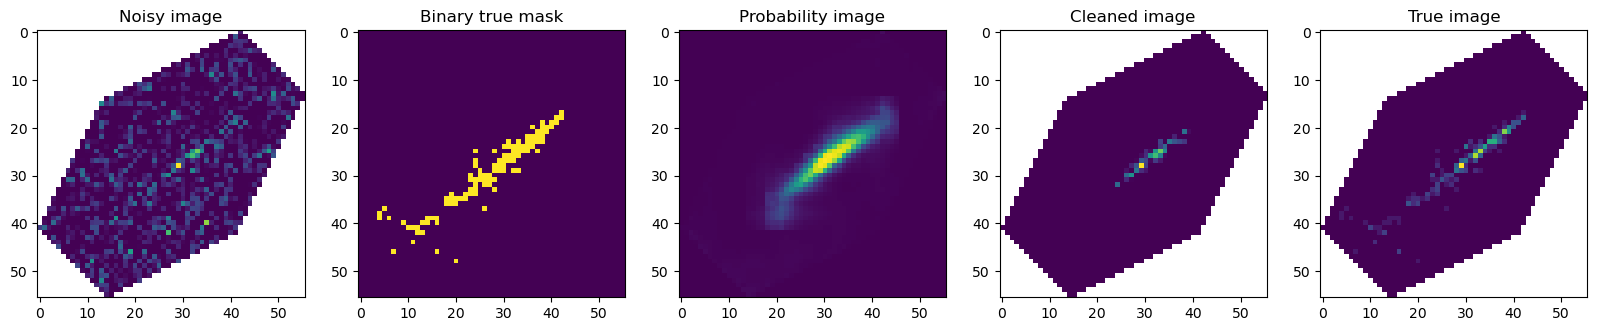

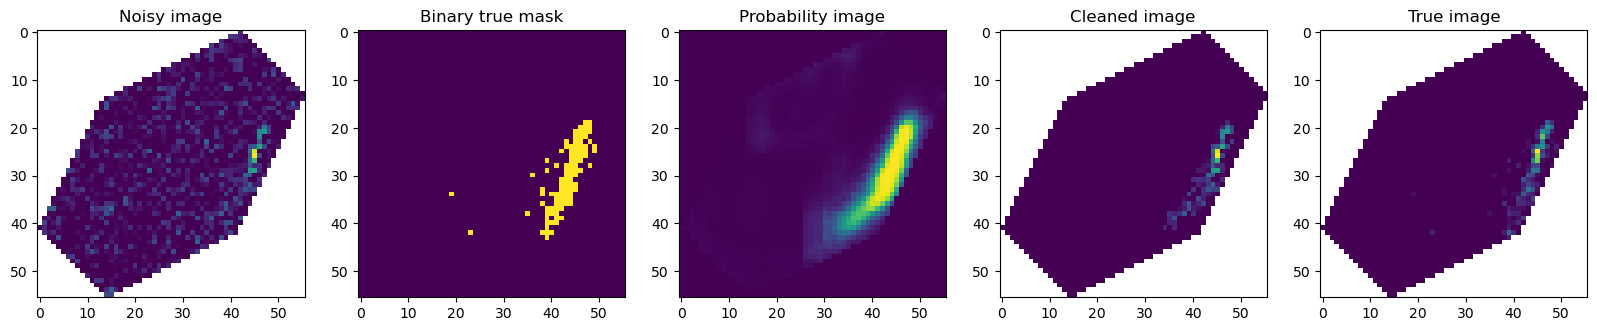

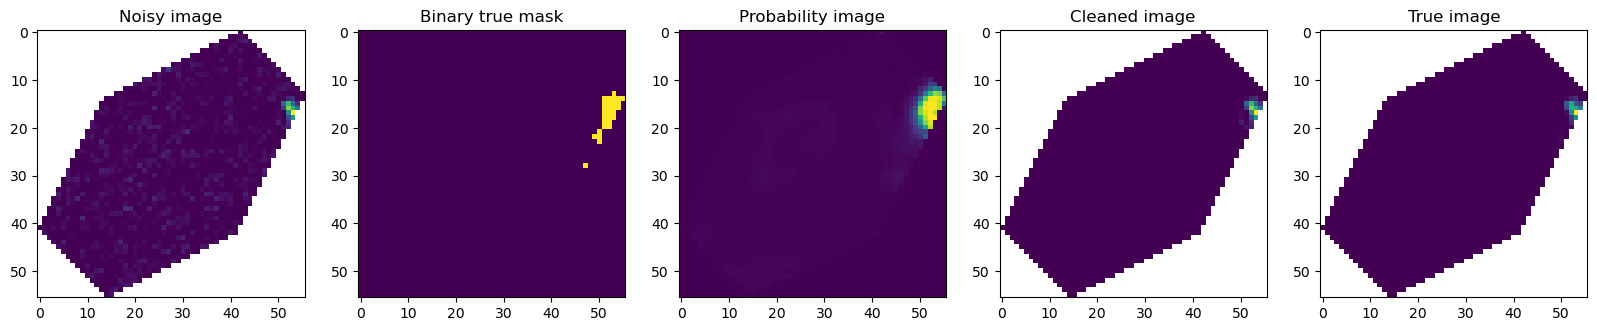

In [24]:
n_start = 10
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network0(data_noisy_test[im_i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**Pixel Threshold > 1**

In [25]:
# Functions and definitions for 
n_epochs = 15

weight = 2

# This is the main training loop
def train(epoch):
    network1.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train): 
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network1(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network1.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true, true_good in zip(data_noisy_test, data_true_test, data_true_test_all):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network1(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true_good)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [26]:
%%time

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

learning_rate = 0.001

network1 = AE4()
optimizer = torch.optim.Adam(network1.parameters(), lr=learning_rate)


data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_aug_threshold(data_noisy, data_true, 1)
    
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)
IOU_all.append(IOU_list)


Test set: Avg. loss: 0.6975
IOU: 0.06597893685102463
Training set: Avg. loss: 0.0897

Test set: Avg. loss: 0.0514
IOU: 0.4291725158691406
Training set: Avg. loss: 0.0646

Test set: Avg. loss: 0.0568
IOU: 0.4628874957561493
Training set: Avg. loss: 0.0606

Test set: Avg. loss: 0.0528
IOU: 0.4737257659435272
Training set: Avg. loss: 0.0582

Test set: Avg. loss: 0.0463
IOU: 0.46470433473587036
Training set: Avg. loss: 0.0571

Test set: Avg. loss: 0.0467
IOU: 0.4698317050933838
Training set: Avg. loss: 0.0558

Test set: Avg. loss: 0.0479
IOU: 0.47772538661956787
Training set: Avg. loss: 0.0552

Test set: Avg. loss: 0.0467
IOU: 0.45211440324783325
Training set: Avg. loss: 0.0548

Test set: Avg. loss: 0.0448
IOU: 0.46217966079711914
Training set: Avg. loss: 0.0540

Test set: Avg. loss: 0.0461
IOU: 0.4858981966972351
Training set: Avg. loss: 0.0532

Test set: Avg. loss: 0.0447
IOU: 0.4711194634437561
Training set: Avg. loss: 0.0531

Test set: Avg. loss: 0.0441
IOU: 0.45493263006210327
Traini

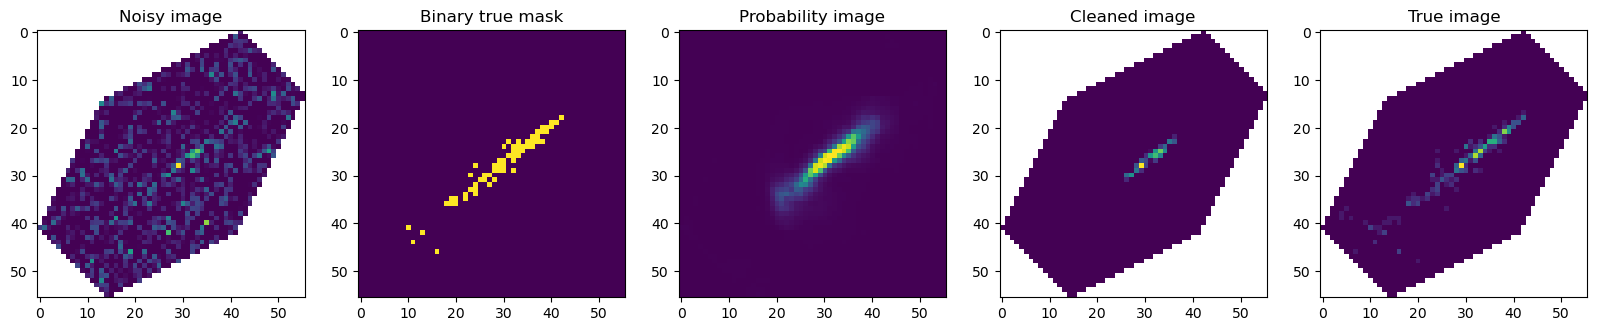

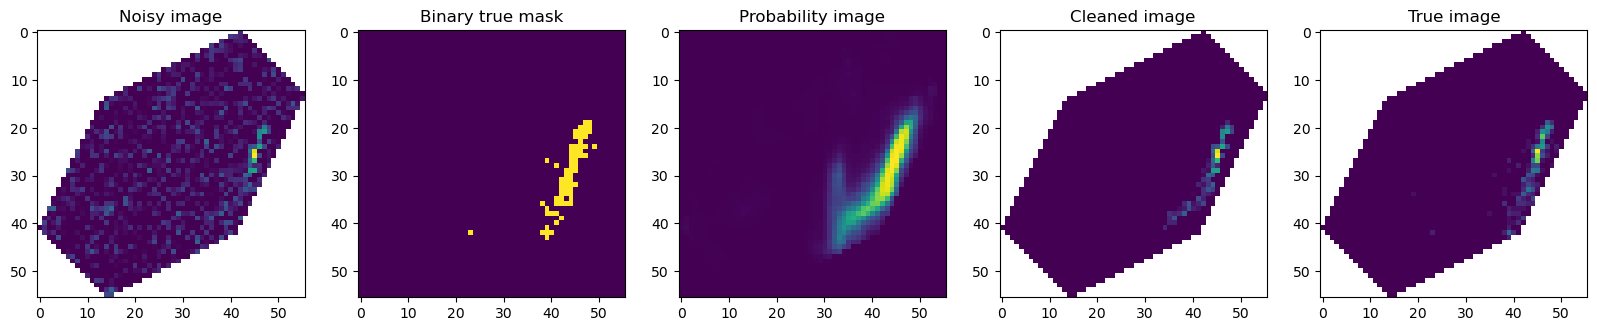

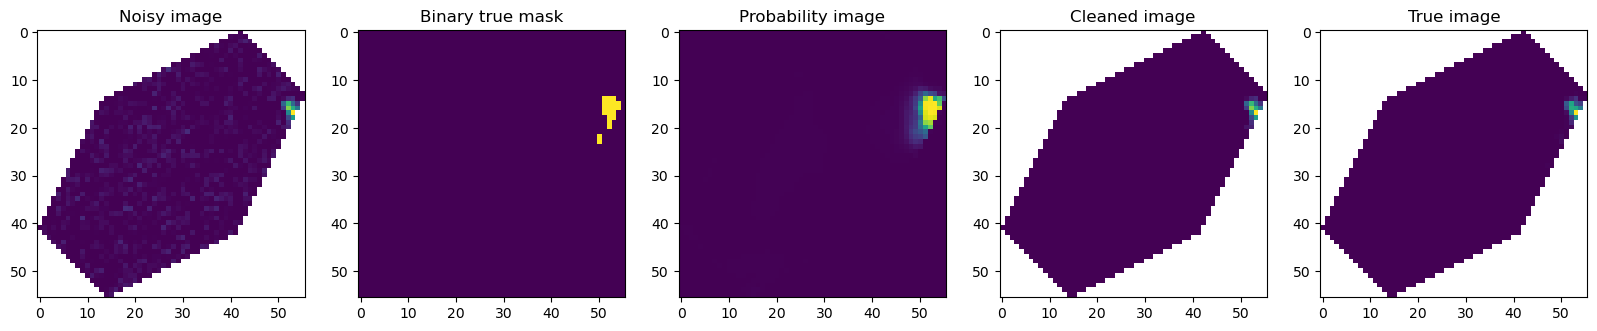

In [27]:
n_start = 10
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network1(data_noisy_test[im_i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")
    #plt.colorbar(fig_clean_prob, ax=axs[2])

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**Pixel threshold > 2**

In [28]:
# Functions and definitions for 
n_epochs = 15

weight = 2

# This is the main training loop
def train(epoch):
    network2.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train): 
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network2(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network2.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true, true_good in zip(data_noisy_test, data_true_test, data_true_test_all):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network2(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true_good)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [29]:
%%time

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

learning_rate = 0.001

network2 = AE4()
optimizer = torch.optim.Adam(network2.parameters(), lr=learning_rate)


data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_aug_threshold(data_noisy, data_true, 2)
    
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)
IOU_all.append(IOU_list)


Test set: Avg. loss: 0.6154
IOU: 0.013318723998963833
Training set: Avg. loss: 0.0594

Test set: Avg. loss: 0.0351
IOU: 0.41491085290908813
Training set: Avg. loss: 0.0454

Test set: Avg. loss: 0.0326
IOU: 0.4230300784111023
Training set: Avg. loss: 0.0415

Test set: Avg. loss: 0.0307
IOU: 0.4141986668109894
Training set: Avg. loss: 0.0396

Test set: Avg. loss: 0.0307
IOU: 0.4010414481163025
Training set: Avg. loss: 0.0383

Test set: Avg. loss: 0.0300
IOU: 0.43550559878349304
Training set: Avg. loss: 0.0378

Test set: Avg. loss: 0.0298
IOU: 0.40148892998695374
Training set: Avg. loss: 0.0370

Test set: Avg. loss: 0.0303
IOU: 0.38472503423690796
Training set: Avg. loss: 0.0369

Test set: Avg. loss: 0.0289
IOU: 0.40883588790893555
Training set: Avg. loss: 0.0364

Test set: Avg. loss: 0.0294
IOU: 0.4286549687385559
Training set: Avg. loss: 0.0362

Test set: Avg. loss: 0.0291
IOU: 0.4019570052623749
Training set: Avg. loss: 0.0358

Test set: Avg. loss: 0.0303
IOU: 0.3776538670063019
Train

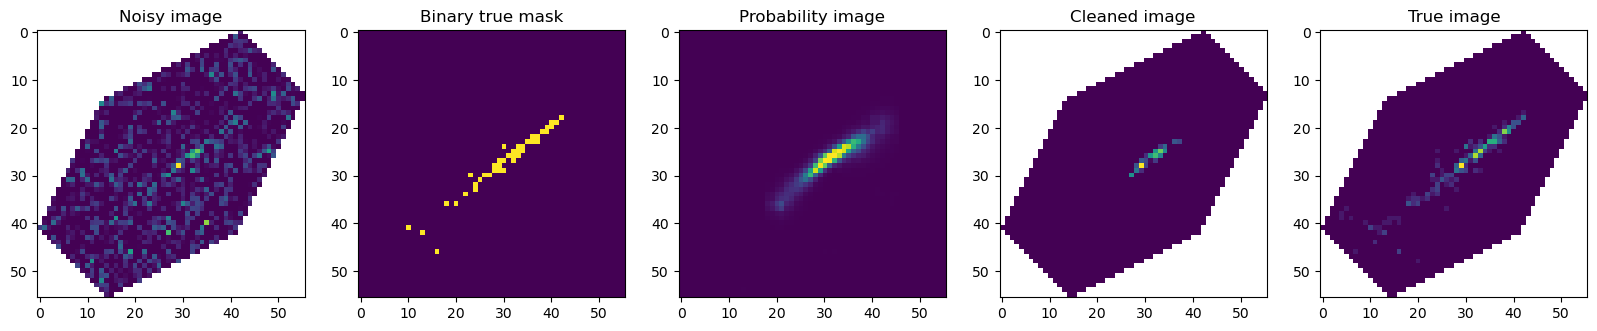

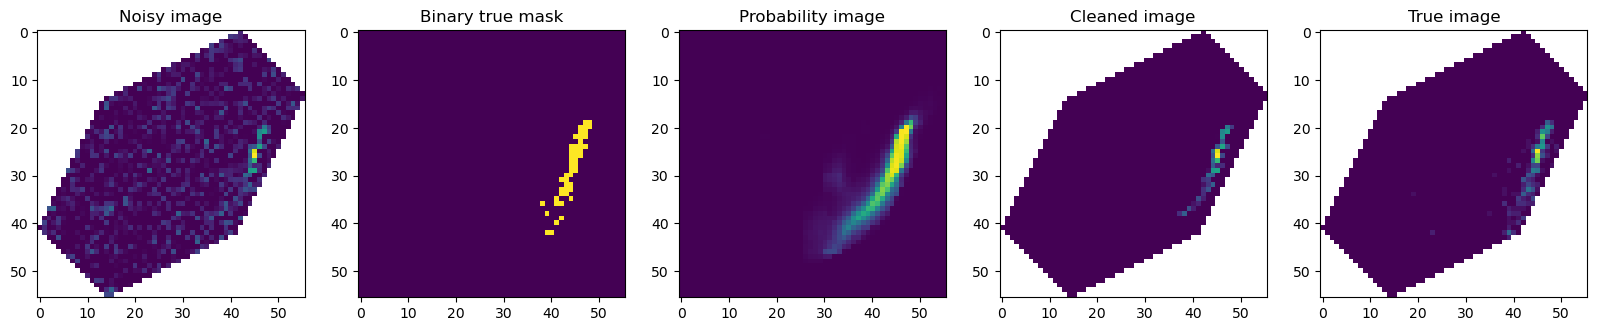

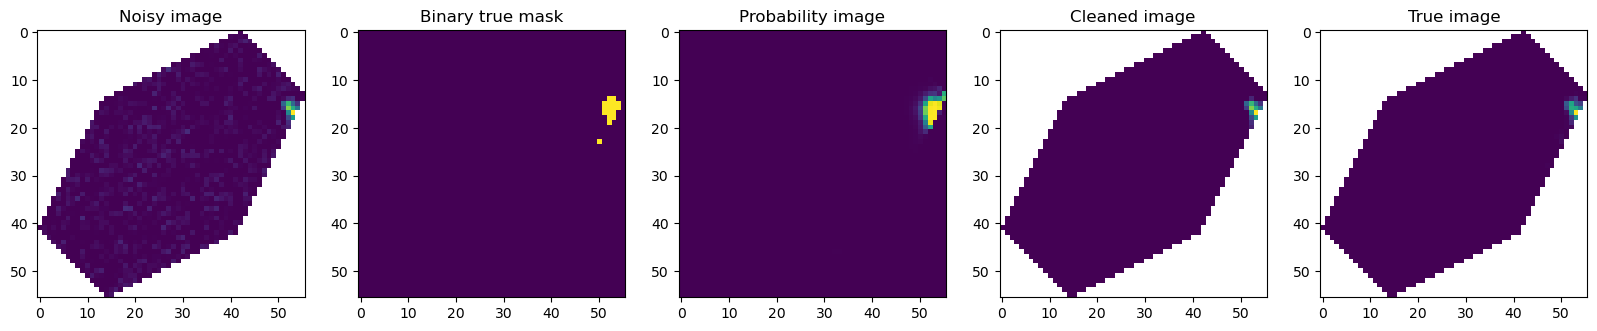

In [30]:
n_start = 10
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network2(data_noisy_test[im_i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**Compare the pixel thresholds**

In [31]:
test_losses_arr = np.array(test_losses_all)
IOU_all_arr = np.array(IOU_all)

In [32]:
print(IOU_all_arr[:, -5:])
#print(np.nanmean(IOU_all_arr[:-3], axis=0))

[[0.48676062 0.49456957 0.4883367  0.49633148 0.49404943]
 [0.45493263 0.43499073 0.46485466 0.4747631  0.45542687]
 [0.37765387 0.43680283 0.39615172 0.40928116 0.41942024]]


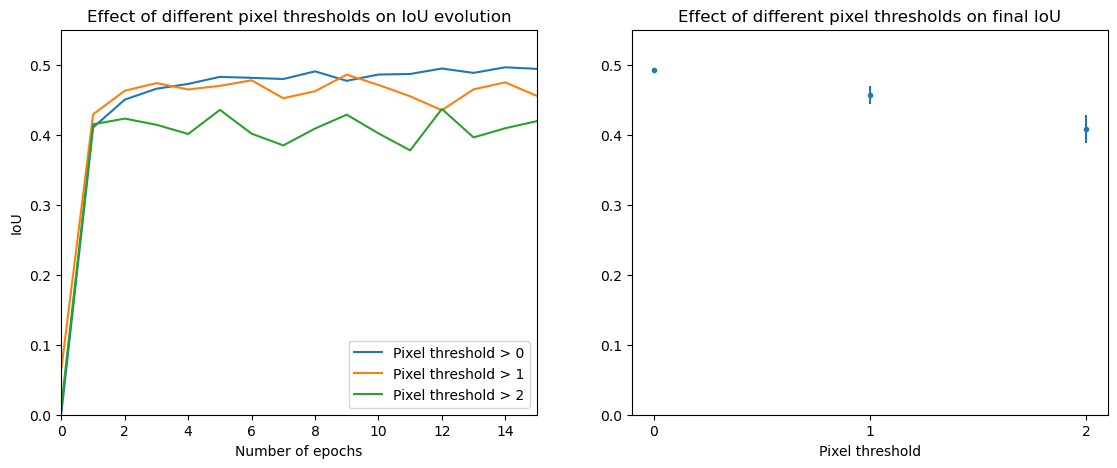

In [43]:
# Plot the fitting results as the loss function and the IoU

fig_pix_thresholds, axs = plt.subplots(1, 2, figsize=(13.5,5))

axs[0].set_title("Effect of different pixel thresholds on IoU evolution")
axs[0].plot(test_counter, IOU_all_arr[0], label='Pixel threshold > 0')
axs[0].plot(test_counter, IOU_all_arr[1], label='Pixel threshold > 1')
axs[0].plot(test_counter, IOU_all_arr[2], label='Pixel threshold > 2')
#axs[0].hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
axs[0].set_xlim(0,n_epochs)
axs[0].set_ylim(0,0.55)
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("IoU")
axs[0].legend()

axs[1].set_title("Effect of different pixel thresholds on final IoU")
axs[1].errorbar(np.array([0,1,2]), np.mean(IOU_all_arr[:, -5:], axis=1), yerr=np.std(IOU_all_arr[:, -5:], axis=1), fmt='.')
#axs[1].hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
axs[1].set_xlabel("Pixel threshold")
#axs[1].set_ylabel("IoU")
axs[1].set_xlim(-0.1, 2.1)
#axs[1].legend()
axs[1].set_ylim(0,0.55)
axs[1].set_xticks([0,1,2], [0,1,2])

plt.show()

fig_pix_thresholds.savefig("images/PixelThresholds.pdf")

Now compare the same image across the different thresholds visually.

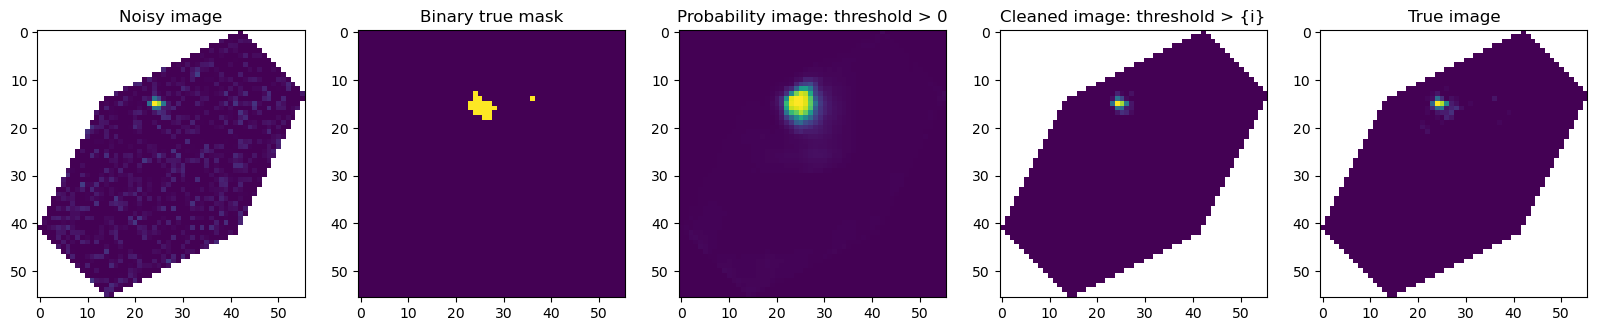

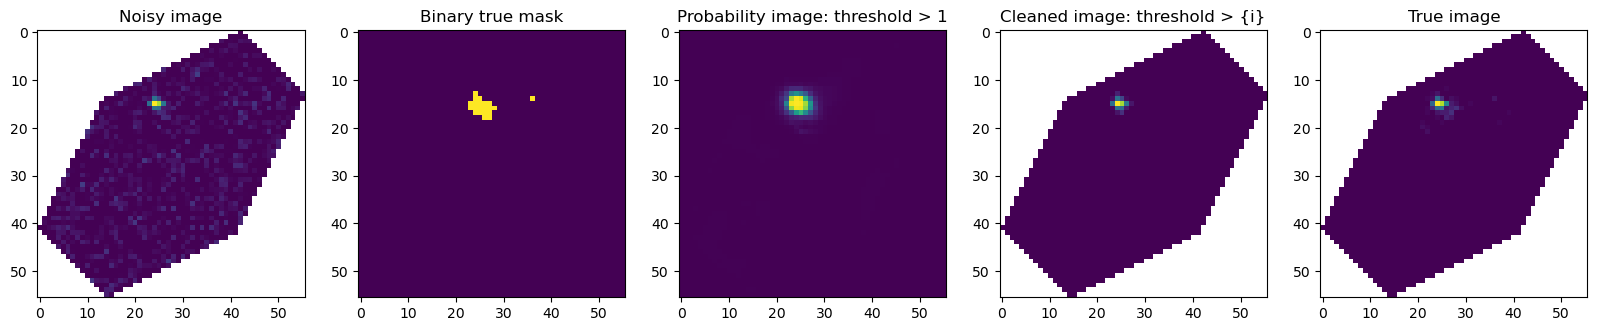

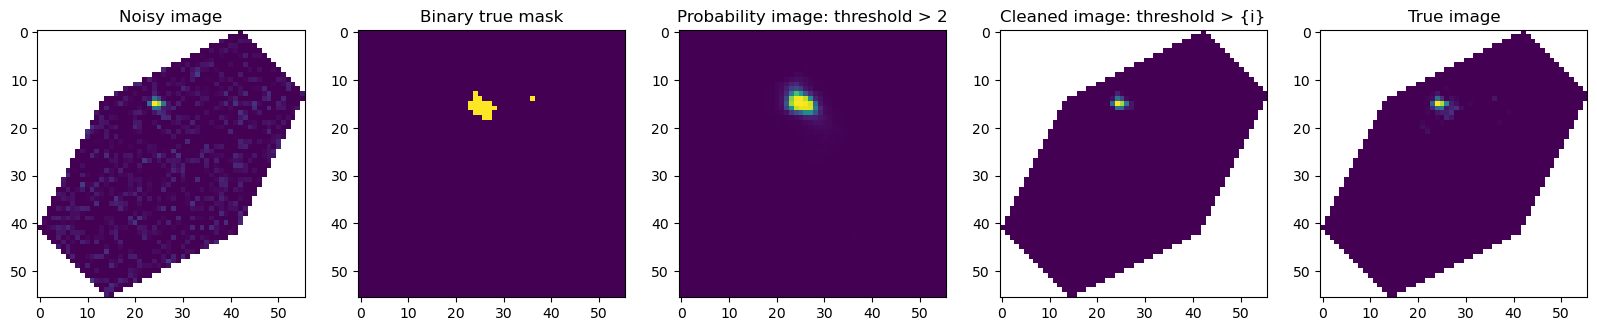

In [44]:
networks = [network0, network1, network2]
im_i = 2

i = 0
for network_i in networks:
    output = network_i(data_noisy_test[im_i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title(f"Probability image: threshold > {i}")

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image: threshold > {i}")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")
    
    i=i+1

plt.show()    